In [2]:
import pandas as pd
import numpy as np
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms

import warnings
warnings.filterwarnings("ignore")

In [3]:
seed = 2023
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [4]:
# models.vgg16_bn(pretrained=False)

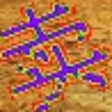

In [5]:
class SNDataset(Dataset):
    
    def __init__(self, image_path, transforms):
        self.image_path = image_path
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        values = self.image_path.iloc[idx]
        img_0_path = values['img_0']
        img_1_path = values['img_1']
        target = values['target']
        
        img_0 = Image.open(img_0_path).convert('RGB')
        img_0 = self.transforms(img_0)
        img_1 = Image.open(img_1_path).convert('RGB')
        img_1 = self.transforms(img_1)
        target = torch.from_numpy(np.array(target, dtype=np.float32))
        
        return img_0, img_1, target


img_size = (112, 112)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
trf = transforms.Compose([
    transforms.Resize(img_size), 
    transforms.ToTensor()
])
# trf_dict = {
#     'train': transforms.Compose([
#         transforms.Resize(img_size),
#         transforms.RandomRotation(degrees=(-10, 10)),
#         transforms.RandomChoice([
#             transforms.ColorJitter(brightness=1),
#             transforms.ColorJitter(contrast=1),
#             transforms.ColorJitter(saturation=0.5),
#             transforms.ColorJitter(hue=0.5),
#             transforms.RandomGrayscale(p=0.5)
#         ]),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=norm_mean, std=norm_std)
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(img_size),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=norm_mean, std=norm_std)
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize(img_size),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=norm_mean, std=norm_std)
#     ])
# }
train_img_path = pd.read_csv('./data/new/train_img_path.csv')
val_img_path = pd.read_csv('./data/new/val_img_path.csv')
test_img_path = pd.read_csv('./data/new/test_img_path.csv')

train_dataset = SNDataset(image_path=train_img_path, transforms=trf)
val_dataset = SNDataset(image_path=val_img_path, transforms=trf)
test_dataset = SNDataset(image_path=test_img_path, transforms=trf)

from torchvision.transforms.functional import to_pil_image
t0, t1, t2 = train_dataset[0]
to_pil_image(t0)
# print(t0.shape)
# print(t2)

In [6]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
for tr_img_0, tr_img_1, tr_label in train_loader:
    print(tr_img_0.shape)
    print(tr_img_1.shape)
    print(tr_label.shape)
    break

torch.Size([16, 3, 112, 112])
torch.Size([16, 3, 112, 112])
torch.Size([16])


In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self, image_size, pretrained=False):
        super(SiameseNetwork, self).__init__()
        
        self.features_net = models.vgg11_bn(pretrained=False)
        if pretrained:
            params = torch.load('./model/vgg11_bn-6002323d.pth')
            self.features_net.load_state_dict(params)
        del self.features_net.avgpool
        del self.features_net.classifier
        
        height, width = image_size[0], image_size[1]
        for _ in range(5):
            height //= 2
            width //= 2
        flat_shape = 512 * height * width
        self.match_net = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(flat_shape, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1)
        )
        # self.match_net = nn.Sequential(
        #     nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        #     nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        #     nn.Flatten(),
        #     nn.Linear(flat_shape, 128),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(128, 1)
        # )
    
    def forward(self, x1, x2):
        x1 = self.features_net.features(x1)
        x2 = self.features_net.features(x2)
        
        # x1 = torch.flatten(x1, 1)
        # x2 = torch.flatten(x2, 1)
        # x = torch.abs(x1 - x2)
        x = torch.cat((x1, x2), 1)
        
        x = self.match_net(x)
        
        return x

siamese_model = SiameseNetwork(image_size=img_size, pretrained=True)
inputs_1 = torch.zeros((32, 3, 112, 112))
inputs_2 = torch.zeros((32, 3, 112, 112))
outputs = siamese_model(inputs_1, inputs_2)
print(outputs.shape)

torch.Size([32, 1])


In [9]:
from sklearn.metrics import accuracy_score

threshold = 0.5
sigmoid = nn.Sigmoid()
def eval_acc(targets, preds):
    targets = targets.cpu().numpy()
    preds = sigmoid(preds)
    preds = preds.detach().cpu().numpy()
    preds = (preds > threshold).astype(int)
    return accuracy_score(targets, preds)

In [20]:
def train(epoch, model, iterator, optimizer, loss_fct, scheduler=None, device='cpu'):
    model.train()
    step = 0
    all_loss = 0
    all_acc = 0
    for img_0, img_1, target in iterator:
        step += 1
        img_0 = img_0.to(device)
        img_1 = img_1.to(device)
        target = target.to(device)
        
        pred = model(img_0, img_1)
        pred = pred.squeeze(-1)
        loss = loss_fct(pred, target)
        all_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        
        acc = eval_acc(target, pred)
        all_acc += acc
    
    print("Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}".format(epoch, all_loss / step, all_acc / step))

def validate(epoch, model, iterator, loss_fct, device):
    model.eval()
    step = 0
    all_loss = 0
    all_acc = 0
    with torch.no_grad():
        for img_0, img_1, target in iterator:
            step += 1
            img_0 = img_0.to(device)
            img_1 = img_1.to(device)
            target = target.to(device)

            pred = model(img_0, img_1)
            pred = pred.squeeze(-1)
            loss = loss_fct(pred, target)
            all_loss += loss.item()

            acc = eval_acc(target, pred)
            all_acc += acc
    
    print("Epoch: {}, Val Loss: {:.4f}, Val Acc: {:.4f}".format(epoch, all_loss / step, all_acc / step))
    return model, all_loss / step, all_acc / step

In [21]:
%%time
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
siamese_model = siamese_model.to(device)
epochs = 30
learn_rate = 0.0001
# adamw = torch.optim.AdamW(siamese_model.parameters(), lr=learn_rate, eps=1e-8)
adamw = torch.optim.Adam(siamese_model.parameters(), lr=learn_rate)
bce_loss = nn.BCEWithLogitsLoss()

best_model = None
best_val_loss = 1e10
best_val_acc = 1e-10

print("start train=============================")
for epoch in range(1, epochs+1):
    train(epoch, model=siamese_model, iterator=train_loader, loss_fct=bce_loss, optimizer=adamw, device=device)
    candidate_model, loss, acc = validate(epoch, model=siamese_model, iterator=val_loader, loss_fct=bce_loss, device=device)
    
    if loss < best_val_loss and acc > best_val_acc:
        best_model = candidate_model
        best_val_loss, best_val_acc = loss, acc
    
    print("===========================================")
print("train finish=============================")

start train=============================
Epoch: 1, Train Loss: 0.7027, Train Acc: 0.4997
Epoch: 1, Val Loss: 0.6983, Val Acc: 0.5319
Epoch: 2, Train Loss: 0.6552, Train Acc: 0.5953
Epoch: 2, Val Loss: 0.4961, Val Acc: 0.7680
Epoch: 3, Train Loss: 0.5026, Train Acc: 0.7542
Epoch: 3, Val Loss: 0.3879, Val Acc: 0.8280
Epoch: 4, Train Loss: 0.3611, Train Acc: 0.8422
Epoch: 4, Val Loss: 0.3034, Val Acc: 0.8656
Epoch: 5, Train Loss: 0.2518, Train Acc: 0.9010
Epoch: 5, Val Loss: 0.2893, Val Acc: 0.8742
Epoch: 6, Train Loss: 0.1564, Train Acc: 0.9437
Epoch: 6, Val Loss: 0.2565, Val Acc: 0.8983
Epoch: 7, Train Loss: 0.1009, Train Acc: 0.9651
Epoch: 7, Val Loss: 0.3381, Val Acc: 0.8971
Epoch: 8, Train Loss: 0.0796, Train Acc: 0.9728
Epoch: 8, Val Loss: 0.2812, Val Acc: 0.9069
Epoch: 9, Train Loss: 0.0474, Train Acc: 0.9832
Epoch: 9, Val Loss: 0.3311, Val Acc: 0.9077
Epoch: 10, Train Loss: 0.0524, Train Acc: 0.9820
Epoch: 10, Val Loss: 0.2515, Val Acc: 0.9154
Epoch: 11, Train Loss: 0.0393, Train 

In [22]:
def test(model, iterator, device):
    model.eval()
    all_acc = 0
    step = 0
    real_target = []
    pred_target = []
    with torch.no_grad():
        for img_0, img_1, target in iterator:
            step += 1
            img_0 = img_0.to(device)
            img_1 = img_1.to(device)
            target = target.to(device)

            pred = model(img_0, img_1)
            pred = pred.squeeze(-1)
            preds = sigmoid(pred)
            preds = preds.detach().cpu().numpy()
            preds = (preds > threshold).astype(int)
            pred_target.extend(preds)
            
            targets = target.cpu().numpy()
            real_target.extend(targets)

            acc = eval_acc(target, pred)
            all_acc += acc
    
    return real_target, pred_target, all_acc / step

In [23]:
y, pred_y, test_acc = test(best_model, test_loader, device)
print("Test Acc: {:.4f}".format(test_acc))
best_val_acc

Test Acc: 0.9338


0.9313725490196079

In [25]:
# torch.save(best_model.state_dict(), './model/siamese_gpu_08_02.pt')

In [49]:
new_model = SiameseNetwork(image_size=img_size, pretrained=True)
new_model.load_state_dict(torch.load('./model/siamese_gpu.pt', map_location=device))
new_model.to(device)

SiameseNetwork(
  (features_net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [50]:
_, _, test_acc = test(new_model, test_loader, device)
print("Test Acc: {:.4f}".format(test_acc))

Test Acc: 0.8510


In [15]:
img_0 = Image.open('./JCxrW.png')
img_1 = Image.open('./Jro9G.png')
img_2 = Image.open('./rGjSk.png')
img_0 = trf(img_0).unsqueeze(0)
img_1 = trf(img_1).unsqueeze(0)
img_2 = trf(img_2).unsqueeze(0)

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
img_0 = img_0.to(device)
img_1 = img_1.to(device)
img_2 = img_2.to(device)
model = SiameseNetwork(image_size=img_size)
model.load_state_dict(torch.load('./model/siamese_gpu_08_02.pt', map_location=device))
model = model.to(device)

In [23]:
pred = model(img_1, img_2)

In [25]:
sigmoid(pred.squeeze(-1))

tensor([1.0000], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [27]:
y = nn.functional.sigmoid(pred.squeeze(-1))

In [29]:
y.detach().cpu().numpy()[0]

0.9999999